In [2]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply

import tqdm
import gc
import sys
import os

import scipy as sp

import json

%cd /data/lyna/Milestone_Error_Analysis_Testing
import analysis_functions

/data/lyna/Milestone_Error_Analysis_Testing


In [3]:
def potFun(x):
    return(0.1*((1/2000)*(x)**6-(x)**2))
def potGradFun(x):
    return(0.1*((6.0/2000)*(x)**5-2.0*(x)))

In [19]:
# Run brute-force DB 
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 
bd_Sim=analysis_functions.Simple_1D_BD_Sim(potGradFun)
bd_Sim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=10,
    verbose=True,
    timestep=0.5
))

nsteps=10000000 #10000k steps = 5 us
trajData=bd_Sim.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))



/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


10000000



binEdges [-8.         -7.05882353 -6.11764706 -5.17647059 -4.23529412 -3.29411765
 -2.35294118 -1.41176471 -0.47058824  0.47058824  1.41176471  2.35294118
  3.29411765  4.23529412  5.17647059  6.11764706  7.05882353  8.        ] binCenters [-7.52941176 -6.58823529 -5.64705882 -4.70588235 -3.76470588 -2.82352941
 -1.88235294 -0.94117647  0.          0.94117647  1.88235294  2.82352941
  3.76470588  4.70588235  5.64705882  6.58823529  7.52941176]
normalized histogram [0.000289 0.024134 0.137016 0.165554 0.094271 0.042601 0.021393 0.014048
 0.011948 0.013366 0.020416 0.040102 0.091386 0.163821 0.1357   0.023656
 0.000299]
pmf [ 3.91147206  1.18606056  0.11653173 -0.          0.34683873  0.83606076
  1.26031446  1.51936002  1.61908727  1.55001177  1.28910551  0.87329401
  0.36598231  0.00648135  0.12247605  1.19838193  3.89052041]


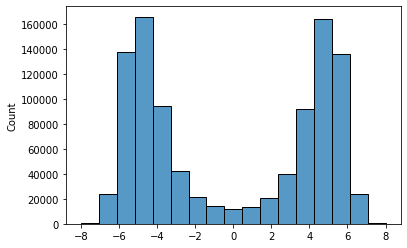

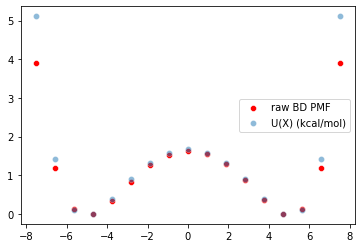

In [20]:
# Plot brute-force BD data and PMF

kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
binEdges=np.linspace(-8,8,18)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binEdges", binEdges, "binCenters",binCenters)

histogram=np.histogram( a=trajData['trajectory'],bins=binEdges)
normHist=histogram[0]/np.sum(histogram[0])
print("normalized histogram", normHist)
print("pmf", -kbT*np.log((normHist)/np.max(normHist)))

sns.histplot(trajData['trajectory'],bins=binEdges)
plt.show()
sns.scatterplot(x=binCenters, y=-kbT*np.log((normHist)/np.max(normHist)), color='r', label="raw BD PMF")
sns.scatterplot(x=binCenters,y=potFun(binCenters)-np.min(potFun(binCenters)),label='U(X) (kcal/mol)', alpha=0.5)
plt.show()

In [7]:


def gen_flat_bottom_harmonic_window_potFun(potFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potFun(x)+.5*kval * ( (x<win_lhs)*(win_lhs-x)**2 + (x>win_rhs)*(win_rhs-x)**2 )
    )
def gen_flat_bottom_harmonic_window_potGradFun(potGradFun,win_lhs,win_rhs,kval):
    return(
        lambda x: potGradFun(x)-kval * ( (x<win_lhs)*(win_lhs-x) + (x>win_rhs)*(win_rhs-x) )
    )



def only_flat_bottom_harmonic_window_potFun(potFun,win_lhs,win_rhs,kval):
    return(
        lambda x: .5*kval * ( (x<win_lhs)*(win_lhs-x)**2 + (x>win_rhs)*(win_rhs-x)**2 )
    )
def only_flat_bottom_harmonic_window_potGradFun(potGradFun,win_lhs,win_rhs,kval):
    return(
        lambda x: -kval * ( (x<win_lhs)*(win_lhs-x) + (x>win_rhs)*(win_rhs-x) )
    )


In [8]:
# Setup milestone potential

binEdges=np.linspace(-8,8,18)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binEdges", binEdges, "binCenters",binCenters)

symm_window_edges=binEdges
symm_window_lhs=symm_window_edges[:-1]
symm_window_rhs=symm_window_edges[1:]
symm_window_centers=binCenters
symm_window_kVals=np.array([100.]*len(symm_window_centers)) # force constant kVal=100
print(symm_window_centers)

symm_window_potFuns=[
    gen_flat_bottom_harmonic_window_potFun(potFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]

symm_window_potGradFuns=[
    gen_flat_bottom_harmonic_window_potGradFun(potGradFun,wlhs,wrhs,wk) \
    for wlhs,wrhs,wk in np.array([
        symm_window_lhs,
        symm_window_rhs,
        symm_window_kVals
    ]).T
]



binEdges [-8.         -7.05882353 -6.11764706 -5.17647059 -4.23529412 -3.29411765
 -2.35294118 -1.41176471 -0.47058824  0.47058824  1.41176471  2.35294118
  3.29411765  4.23529412  5.17647059  6.11764706  7.05882353  8.        ] binCenters [-7.52941176 -6.58823529 -5.64705882 -4.70588235 -3.76470588 -2.82352941
 -1.88235294 -0.94117647  0.          0.94117647  1.88235294  2.82352941
  3.76470588  4.70588235  5.64705882  6.58823529  7.52941176]
[-7.52941176 -6.58823529 -5.64705882 -4.70588235 -3.76470588 -2.82352941
 -1.88235294 -0.94117647  0.          0.94117647  1.88235294  2.82352941
  3.76470588  4.70588235  5.64705882  6.58823529  7.52941176]


win 0
win 1
win 2
win 3
win 4
win 5
win 6
win 7
win 8
win 9
win 10
win 11
win 12
win 13
win 14
win 15
win 16


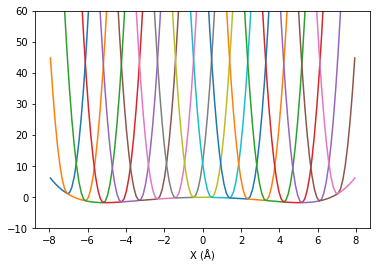

In [9]:
# plot milestone potential before running

winPot=[]
winPotGrad=[]
for win in np.arange(0,len(symm_window_centers)):
    print("win",win)
    winPot=symm_window_potFuns[win]
    winPotGrad=symm_window_potGradFuns[win]
    
    binEdges=np.linspace(-8,8,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters

    sns.lineplot(
        x=xgrid,
        y=winPot(xgrid),
        #label='symm_win_%02g_U(x)'%win
    )
    

plt.xlabel('X (Å)')
plt.ylim(-10,60)
plt.show()

kbT 0.6159191312499999
symm_window_centers [-7.52941176 -6.58823529 -5.64705882 -4.70588235 -3.76470588 -2.82352941
 -1.88235294 -0.94117647  0.          0.94117647  1.88235294  2.82352941
  3.76470588  4.70588235  5.64705882  6.58823529  7.52941176]


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5000000


/home/lyna/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


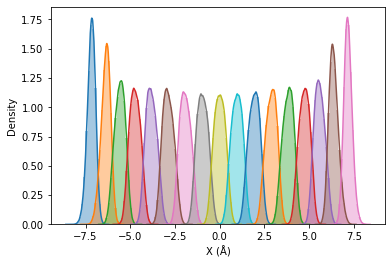

In [23]:
# Run milestoning

diffCoef=.0282*310.15/298.15
kb=0.001985875
Tsim=310.15
kbT=kb*Tsim
print("kbT",kbT, )
print("symm_window_centers",symm_window_centers)

symm_win_sim_data=[]
for iWin,winCenter in enumerate(symm_window_centers):
    win_potGradFun=symm_window_potGradFuns[iWin]
    bd_Sim=analysis_functions.Simple_1D_BD_Sim(win_potGradFun)
    bd_Sim.set_parameters(dict(
        diffusionConstant=diffCoef,
        vmax=15.0,
        trajectorySnapshotRate=10,
        verbose=True,
        timestep=0.5
    ))
    bd_Sim.set_x0(winCenter)

    nsteps=5000000 #5000k steps x8 windows x 0.5 fs= 20 us, sufficeint to converge brute-force BD
    symm_win_sim_data.append(bd_Sim.run_sim(nsteps=nsteps,giveVelocities=True,
        pbar=tqdm.tqdm_notebook(total=nsteps)))
    trajData=symm_win_sim_data[iWin]
    binEdges=np.linspace(-8,8,130)
    binCenters=(binEdges[:-1]+binEdges[1:])/2.
    xgrid=binCenters
    sns.distplot(trajData['trajectory'],bins=binEdges, color=None)

plt.xlabel('X (Å)')
plt.show()

In [24]:
# Save milestoning data

for iWin,winData in enumerate(symm_win_sim_data):
    stepsPerWindow=(len(winData['trajectory']))
print(stepsPerWindow)

milestone_data_table=pd.DataFrame({
    'Window':(np.array([[iWin]*len(winData['trajectory']) for iWin,winData in enumerate(symm_win_sim_data)])).flatten(),
    'X':(np.array([winData['trajectory'] for winData in symm_win_sim_data])).flatten(),
    "WindowCenter":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])).flatten()),
    #"WindowLeft":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])-1.5).flatten()),
    #"WindowRight":((np.array([[winCenter]*stepsPerWindow for iWin,winCenter in enumerate(symm_window_centers)])+1.5).flatten()),
})
milestone_data_table['X_Ind']=milestone_data_table['X'].map(lambda x: np.argmin(np.abs(x-symm_window_centers)))
milestone_data_table
milestone_data_table.to_csv('data_window.csv',index=False)

symm_window_data=pd.DataFrame({
    'Window':np.arange(len(symm_window_centers)),
    'LHS_Edge':symm_window_lhs,
    'Center':symm_window_centers,
    'RHS_Edge':symm_window_rhs
})
print('saving window setup data')
display(symm_window_data.head())
symm_window_data.to_csv('setup_windows.csv',index=False)

500000
saving window setup data


,Window,LHS_Edge,Center,RHS_Edge
0,0,-8.000000,-7.529412,-7.058824
1,1,-7.058824,-6.588235,-6.117647
2,2,-6.117647,-5.647059,-5.176471
3,3,-5.176471,-4.705882,-4.235294
4,4,-4.235294,-3.764706,-3.294118


In [25]:
# Compute milestoning PMF

# add a frame column for each window
milestoneSimulationsData=milestone_data_table
print(milestoneSimulationsData.head())

tempFrames=[]
with tqdm.tqdm_notebook(milestoneSimulationsData.groupby(['Window'])) as pbar:
    for group in pbar:
        groupName,groupData=group
        tempFrame=groupData.copy()
        tempFrame['Frame']=np.arange(len(tempFrame))
        tempFrame['Replica']=0
        tempFrame=tempFrame[['Replica','Window','Frame','X','X_Ind']]
        tempFrames.append(tempFrame.copy())
        gc.collect()
milestoneSimulationsData=pd.concat(tempFrames)
milestoneSimulationsData

   Window         X  WindowCenter  X_Ind
0       0 -7.529412     -7.529412      0
1       0 -7.017491     -7.529412      1
2       0 -7.117359     -7.529412      0
3       0 -7.391263     -7.529412      0
4       0 -7.213458     -7.529412      0


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,Replica,Window,Frame,X,X_Ind
0,0,0,0,-7.529412,0
1,0,0,1,-7.017491,1
2,0,0,2,-7.117359,0
3,0,0,3,-7.391263,0
4,0,0,4,-7.213458,0
...,...,...,...,...,...
8499995,0,16,499995,7.142526,16
8499996,0,16,499996,7.314528,16
8499997,0,16,499997,7.249353,16
8499998,0,16,499998,6.773299,15


In [26]:
milestoneData=analysis_functions.add_indexed_milestoning_analysis_columns(
    milestoneSimulationsData,
    windowColumn='Window',xIndexColumn='X_Ind',frameCol='Frame',
    repColumn=None,groupingColumn=None,verbose=True,
    verboseLevel=0
)
milestoneData["X"]=milestoneSimulationsData.X
milestoneData

/data/lyna/Milestone_Error_Analysis_Testing/analysis_functions.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[groupingCol]=0
/data/lyna/Milestone_Error_Analysis_Testing/analysis_functions.py:436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simData[repCol]=0


--- --- --- Grouping Name: 0 --- --- ---
	--- --- Window Name: 0 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 1 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 2 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 3 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 4 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 5 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 6 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 7 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 8 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 9 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 10 --- ---
		--- Replica Name: 0 ---
	--- --- ------ --- ---
	--- --- Window Name: 11 --- ---
		--- Replica Name: 0 -

,Window,X_Ind,Group,Rep,Frame,Escape_Vector,Reentry_Vector,X
0,0,0,0,0,0,0,-1,-7.529412
1,0,1,0,0,1,1,-1,-7.017491
2,0,0,0,0,2,0,1,-7.117359
3,0,0,0,0,3,0,1,-7.391263
4,0,0,0,0,4,0,1,-7.213458
...,...,...,...,...,...,...,...,...
8499995,16,16,0,0,499995,16,15,7.142526
8499996,16,16,0,0,499996,16,15,7.314528
8499997,16,16,0,0,499997,16,15,7.249353
8499998,16,15,0,0,499998,15,15,6.773299


In [27]:
#################### pi_vector and PMF ################

kb=0.001985875 #kcal/mol
simTemp=310.15
kbT=kb*simTemp

analysisFrame=milestoneData
binSet=np.sort(np.unique(np.concatenate([
    analysisFrame['Window'].unique(),
    analysisFrame['X_Ind'].unique()
])))
print("binSet",binSet)

testEscapeData=analysis_functions.compute_analysis_group_pi_vector(
    groupDataFrame=analysisFrame,windowColumn='Window',binSet=binSet,
    giveEscapeMat=True,giveCounts=True,giveBins=True,giveBinMap=True,
    giveCountsMat=True)
print('testEscapeData:',testEscapeData)

# escapeMat is the number of escape per frame, kij and kji, row sum must be 1


binSet [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
testEscapeData: {'piVec': array([0.00064673, 0.02802529, 0.12591584, 0.14759112, 0.09023662,
       0.04644309, 0.02647488, 0.0188854 , 0.01676047, 0.01893718,
       0.0273927 , 0.0479631 , 0.0932472 , 0.15290251, 0.12978363,
       0.02814088, 0.00065335]), 'escapeMat': <17x17 sparse matrix of type '<class 'numpy.float64'>'
	with 49 stored elements in List of Lists format>, 'counts': array([339671, 411029, 438279, 436365, 431653, 430319, 430410, 431870,
       431947, 431628, 430759, 430296, 432018, 436388, 438407, 410710,
       339649]), 'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'binMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16}, 'binSetMap': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16}, 'countsMat': <17x17 sparse matrix of type '<clas

pmf [4.52305357 2.20169403 1.27627163 1.17844393 1.48148258 1.89058079
 2.23674665 2.44480855 2.51832823 2.44312207 2.21575602 1.87074551
 1.4612689  1.15666825 1.257637   2.19915884 4.51678062]
window center [-7.52941176 -6.58823529 -5.64705882 -4.70588235 -3.76470588 -2.82352941
 -1.88235294 -0.94117647  0.          0.94117647  1.88235294  2.82352941
  3.76470588  4.70588235  5.64705882  6.58823529  7.52941176]


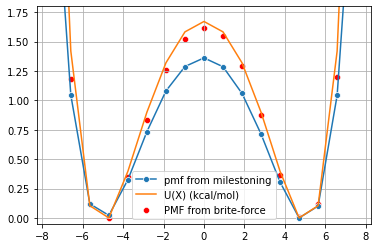

In [91]:
piVec=testEscapeData['piVec']
#sns.lineplot(np.arange(len(piVec)),piVec, marker='o', color='g', label="piVec")
pmfVec=-kbT*np.log(testEscapeData['piVec'])
print("pmf", pmfVec)
pmfVec=pmfVec-np.min(pmfVec)
xgrid=symm_window_centers
print("window center",xgrid)
sns.lineplot(
    x=xgrid,
    y=pmfVec, marker='o',label="pmf from milestoning")

sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)
offset=np.min(potFun(xgrid))
sns.scatterplot(x=xgrid, y=-kbT*np.log((normHist)/np.max(normHist)), color='r', label="PMF from brite-force")
plt.ylim(-0.05, 1.80)
plt.grid()
plt.show()

binEdges [-8.         -7.05882353 -6.11764706 -5.17647059 -4.23529412 -3.29411765
 -2.35294118 -1.41176471 -0.47058824  0.47058824  1.41176471  2.35294118
  3.29411765  4.23529412  5.17647059  6.11764706  7.05882353  8.        ]
binCenters [-7.52941176 -6.58823529 -5.64705882 -4.70588235 -3.76470588 -2.82352941
 -1.88235294 -0.94117647  0.          0.94117647  1.88235294  2.82352941
  3.76470588  4.70588235  5.64705882  6.58823529  7.52941176]
kbT 0.6159191312499999
-1.717590452493373


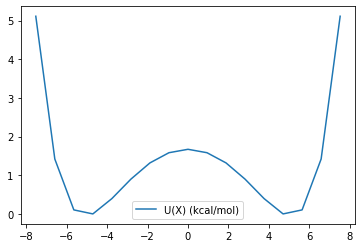

In [97]:
binEdges=np.linspace(-8,8,18)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binEdges", binEdges)
print("binCenters",binCenters)
print("kbT", kbT)

sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)
offset=np.min(potFun(binEdges))
print(offset)

In [37]:
print(-kbT*np.log(testEscapeData['piVec']))

[4.52305357 2.20169403 1.27627163 1.17844393 1.48148258 1.89058079
 2.23674665 2.44480855 2.51832823 2.44312207 2.21575602 1.87074551
 1.4612689  1.15666825 1.257637   2.19915884 4.51678062]


In [132]:
V1 = 0.1*((1/2000)*xx**6-xx**2)
xedge=np.linspace(-8,8,5)
print(xedge)
for i in np.arange(0,4):
    print(i, xedge[i], i+1, xedge[i+1])
    print(-kbT*np.log(np.trapz(x, np.exp(-V1/kbT))))


[-8. -4.  0.  4.  8.]
0 -8.0 1 -4.0
1 -4.0 2 0.0
2 0.0 3 4.0
3 4.0 4 8.0


0 -8.0 1 -7.0588235294117645
1 -7.0588235294117645 2 -6.117647058823529
2 -6.117647058823529 3 -5.176470588235294
3 -5.176470588235294 4 -4.235294117647059
4 -4.235294117647059 5 -3.2941176470588234
5 -3.2941176470588234 6 -2.3529411764705888
6 -2.3529411764705888 7 -1.4117647058823533
7 -1.4117647058823533 8 -0.47058823529411775
8 -0.47058823529411775 9 0.47058823529411775
9 0.47058823529411775 10 1.4117647058823533
10 1.4117647058823533 11 2.3529411764705888
11 2.3529411764705888 12 3.2941176470588225
12 3.2941176470588225 13 4.235294117647058
13 4.235294117647058 14 5.1764705882352935


/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/cm/shared/apps/jupyter/11.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountere

14 5.1764705882352935 15 6.117647058823529
15 6.117647058823529 16 7.0588235294117645
16 7.0588235294117645 17 8.0


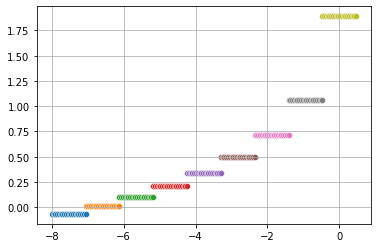

In [125]:
V1 = 0.1*((1/2000)*xx**6-xx**2)
for ii in np.arange(0,17):
    print(ii, binEdges[ii], ii+1, binEdges[ii+1])
    xx=np.linspace(binEdges[ii],binEdges[ii+1],20)
    #sns.scatterplot(x=xx, y=V1/kbT, alpha=0.1)
    #print(-kbT*np.log(np.trapz(xx, np.exp(-V1/kbT))))
    sns.scatterplot(x=xx, y=-kbT*np.log(np.trapz(xx, np.exp(-V1/kbT))))
#plt.ylim(-1, 2)
plt.grid()
plt.show()
    #sns.scatterplot(np.exp(-potFun(xx)/kbT))
    #plt.show()
    #print(-kbT*np.log(np.trapz(xx,np.exp(-potFun(xx)/kbT))))